# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [1]:
#result
#ver1:LGB、lgb cv mean QWK score : 0.5208321783509067、LB：0.536(+0.015)
#ver2:0.8LGB+0.2XGB
#lgb cv mean QWK score : 0.5076390431140777、xgb cv mean QWK score : 0.49945107302527625
#LB：0.534
#ver4:LGB+XGB(LidgeでEnsemble)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [2]:
import warnings
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import scipy as sp
import multiprocessing
import scipy as sp
import time
import random
import json

from multiprocessing import Lock, Process, Queue, current_process
from math import sqrt
from numba import jit
from functools import partial
from tqdm import tqdm as tqdm
from collections import Counter
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from catboost import CatBoostRegressor
np.random.seed(724)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000)
pd.set_option('max_rows', 500)

In [3]:
def read_data():
    start = time.time()
    print("Start read data")

    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    #train = pd.read_csv('../input/data-science-bowl-2019/train.csv', nrows=1200000)
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    #test = pd.read_csv('../input/data-science-bowl-2019/test.csv', nrows=30000)

    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))

    print("read data done, time - ", time.time() - start)
    return train, test, train_labels, specs, sample_submission

In [4]:
def encode_title(train, test, train_labels):
    start = time.time()

    print("Start encoding data")
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))

    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = list(set(train["type_world"].unique()).union(test["type_world"].unique()))

    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(
        set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100 * np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    print("End encoding data, time - ", time.time() - start)


    event_data = {}
    event_data["train_labels"] = train_labels
    event_data["win_code"] = win_code
    event_data["list_of_user_activities"] = list_of_user_activities
    event_data["list_of_event_code"] = list_of_event_code
    event_data["activities_labels"] = activities_labels
    event_data["assess_titles"] = assess_titles
    event_data["list_of_event_id"] = list_of_event_id
    event_data["all_title_event_code"] = all_title_event_code
    event_data["activities_map"] = activities_map
    event_data["all_type_world"] = all_type_world

    return train, test, event_data
def get_all_features(feature_dict, ac_data):
    if len(ac_data['durations']) > 0:
        feature_dict['installation_duration_mean'] = np.mean(ac_data['durations'])
        feature_dict['installation_duration_sum'] = np.sum(ac_data['durations'])
    else:
        feature_dict['installation_duration_mean'] = 0
        feature_dict['installation_duration_sum'] = 0

    return feature_dict
def get_data(user_sample, event_data, test_set):
    '''
    The user_sample is a DataFrame from train or test where the only one
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_assesment = {}

    last_activity = 0

    user_activities_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}

    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy': 0,
                            'Mushroom Sorter (Assessment)_4020_accuracy': 0,
                            'Bird Measurer (Assessment)_4020_accuracy': 0,
                            'Chest Sorter (Assessment)_4020_accuracy': 0}

    game_time_dict = {'Clip_gametime': 0, 'Game_gametime': 0,
                      'Activity_gametime': 0, 'Assessment_gametime': 0}

    last_session_time_sec = 0
    accuracy_groups = {0: 0, 1: 0, 2: 0, 3: 0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0

    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0

    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    durations_game = []
    durations_activity = []
    last_accuracy_title = {'acc_' + title: -1 for title in event_data["assess_titles"]}
    last_game_time_title = {'lgt_' + title: 0 for title in event_data["assess_titles"]}
    ac_game_time_title = {'agt_' + title: 0 for title in event_data["assess_titles"]}
    ac_true_attempts_title = {'ata_' + title: 0 for title in event_data["assess_titles"]}
    ac_false_attempts_title = {'afa_' + title: 0 for title in event_data["assess_titles"]}
    event_code_count: dict[str, int] = {ev: 0 for ev in event_data["list_of_event_code"]}
    event_code_proc_count = {str(ev) + "_proc" : 0. for ev in event_data["list_of_event_code"]}
    event_id_count: dict[str, int] = {eve: 0 for eve in event_data["list_of_event_id"]}
    title_count: dict[str, int] = {eve: 0 for eve in event_data["activities_labels"].values()}
    title_event_code_count: dict[str, int] = {t_eve: 0 for t_eve in event_data["all_title_event_code"]}
    type_world_count: dict[str, int] = {w_eve: 0 for w_eve in event_data["all_type_world"]}
    session_count = 0

    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = event_data["activities_labels"][session_title]

        if session_type == "Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1]) / 2.0

        if session_type == "Game":
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1]) / 2.0

            game_s = session[session.event_code == 2030]
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt

            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round = (mean_game_round + game_round) / 2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) / 2.0
            except:
                pass

            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) / 2.0
            except:
                pass

        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session) > 1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {event_data["win_code"][session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens:
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            features.update(last_game_time_title.copy())
            features.update(ac_game_time_title.copy())
            features.update(ac_true_attempts_title.copy())
            features.update(ac_false_attempts_title.copy())

            features.update(event_code_proc_count.copy())
            features['installation_session_count'] = session_count
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum

            variety_features = [('var_event_code', event_code_count),
                                ('var_event_id', event_id_count),
                                ('var_title', title_count),
                                ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]

            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)

            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts

            # ----------------------------------------------
            ac_true_attempts_title['ata_' + session_title_text] += true_attempts
            ac_false_attempts_title['afa_' + session_title_text] += false_attempts

            last_game_time_title['lgt_' + session_title_text] = session['game_time'].iloc[-1]
            ac_game_time_title['agt_' + session_title_text] += session['game_time'].iloc[-1]
            # ----------------------------------------------

            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
                features['last_duration'] = 0
                features['duration_max'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['last_duration'] = durations[-1]
                features['duration_max'] = np.max(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

            if durations_game == []:
                features['duration_game_mean'] = 0
                features['duration_game_std'] = 0
                features['game_last_duration'] = 0
                features['game_max_duration'] = 0
            else:
                features['duration_game_mean'] = np.mean(durations_game)
                features['duration_game_std'] = np.std(durations_game)
                features['game_last_duration'] = durations_game[-1]
                features['game_max_duration'] = np.max(durations_game)

            if durations_activity == []:
                features['duration_activity_mean'] = 0
                features['duration_activity_std'] = 0
                features['game_activity_duration'] = 0
                features['game_activity_max'] = 0
            else:
                features['duration_activity_mean'] = np.mean(durations_activity)
                features['duration_activity_std'] = np.std(durations_activity)
                features['game_activity_duration'] = durations_activity[-1]
                features['game_activity_max'] = np.max(durations_activity)

            # the accuracy is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0
            # --------------------------
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025 / counter if counter > 0 else 0

            Assess_4025 = session[(session.event_code == 4025) & (session.title == 'Cauldron Filler (Assessment)')]
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_) if (
                                                                                                      true_attempts_ + false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_

            chest_assessment_uncorrect_sum += len(session[session.event_id == "df4fe8b6"])

            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1]) / 2.0
            # ----------------------------
            accuracy = true_attempts / (true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions

            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                last_assesment = features.copy()

            if true_attempts + false_attempts > 0:
                all_assessments.append(features)

            counter += 1

        if session_type == 'Game':
            durations_game.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

        if session_type == 'Activity':
            durations_activity.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

        session_count += 1

        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = event_data["activities_labels"][k]
                counter[x] += num_of_session_count[k]
            return counter

        def update_proc(count: dict):
            res = {}
            for k, val in count.items():
                res[str(k) + "_proc"] = (float(val) * 100.0) / accumulated_actions
            return res

        event_code_count = update_counters(event_code_count, "event_code")


        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')

        assess_4020_acc_dict = get_4020_acc(session, assess_4020_acc_dict, event_data)
        game_time_dict[session_type + '_gametime'] = (game_time_dict[session_type + '_gametime'] + (
                    session['game_time'].iloc[-1] / 1000.0)) / 2.0

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        event_code_proc_count = update_proc(event_code_count)

        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

            # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return last_assesment, all_assessments
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df, counter_dict, event_data):
    for e in ['Cauldron Filler (Assessment)', 'Bird Measurer (Assessment)',
              'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)']:
        Assess_4020 = df[(df.event_code == 4020) & (df.title == event_data["activities_map"][e])]
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_) if (
                                                                                                      true_attempts_ + false_attempts_) != 0 else 0
        counter_dict[e + "_4020_accuracy"] += (counter_dict[e + "_4020_accuracy"] + measure_assess_accuracy_) / 2.0

    return counter_dict

def get_users_data(users_list, return_dict,  event_data, test_set):
    if test_set:
        for user in users_list:
            return_dict.append(get_data(user, event_data, test_set))
    else:
        answer = []
        for user in users_list:
            answer += get_data(user, event_data, test_set)
        return_dict += answer

def get_data_parrallel(users_list, event_data, test_set):
    manager = multiprocessing.Manager()
    return_dict = manager.list()
    threads_number = event_data["process_numbers"]
    data_len = len(users_list)
    processes = []
    cur_start = 0
    cur_stop = 0
    for index in range(threads_number):
        cur_stop += (data_len-1) // threads_number

        if index != (threads_number - 1):
            p = Process(target=get_users_data, args=(users_list[cur_start:cur_stop], return_dict, event_data, test_set))
        else:
            p = Process(target=get_users_data, args=(users_list[cur_start:], return_dict, event_data, test_set))

        processes.append(p)
        cur_start = cur_stop

    for proc in processes:
        proc.start()

    for proc in processes:
        proc.join()

    return list(return_dict)

def get_train_and_test(train, test, event_data):
    start = time.time()
    print("Start get_train_and_test")

    compiled_train = []
    compiled_test = []

    user_train_list = []
    user_test_list = []

    stride_size = event_data["strides"]
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
        user_train_list.append(user_sample)
        if (i + 1) % stride_size == 0:
            compiled_train += get_data_parrallel(user_train_list, event_data, False)
            del user_train_list
            user_train_list = []

    if len(user_train_list) > 0:
        compiled_train += get_data_parrallel(user_train_list, event_data, False)
        del user_train_list

    for i, (ins_id, user_sample) in tqdm(enumerate(test.groupby('installation_id', sort=False)), total=1000):
        user_test_list.append(user_sample)
        if (i + 1) % stride_size == 0:
            compiled_test += get_data_parrallel(user_test_list, event_data, True)
            del user_test_list
            user_test_list = []

    if len(user_test_list) > 0:
        compiled_test += get_data_parrallel(user_test_list, event_data, True)
        del user_test_list

    reduce_train = pd.DataFrame(compiled_train)

    reduce_test = [x[0] for x in compiled_test]

    reduce_train_from_test = []
    for i in [x[1] for x in compiled_test]:
        reduce_train_from_test += i

    reduce_test = pd.DataFrame(reduce_test)
    reduce_train_from_test = pd.DataFrame(reduce_train_from_test)
    print("End get_train_and_test, time - ", time.time() - start)
    return reduce_train, reduce_test, reduce_train_from_test

def get_train_and_test_single_proc(train, test, event_data):
    compiled_train = []
    compiled_test = []
    compiled_test_his = []
    for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False), total=17000):
        compiled_train += get_data(user_sample, event_data, False)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
        test_data = get_data(user_sample, event_data, True)
        compiled_test.append(test_data[0])
        compiled_test_his += test_data[1]


    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_test_his = pd.DataFrame(compiled_test_his)

    return reduce_train, reduce_test, reduce_test_his

In [5]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [6]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [7]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [8]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [9]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [10]:
in_kaggle = True
#random.seed(42)
start_program = time.time()

event_data = {}
if in_kaggle:
    event_data["strides"] = 300
    event_data["process_numbers"] = 4
else:
    event_data["strides"] = 300
    event_data["process_numbers"] = 3

In [11]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, event_data_update = encode_title(train, test, train_labels)
event_data.update(event_data_update)

#reduce_train, reduce_test, reduce_train_from_test = get_train_and_test_single_proc(train, test, event_data)
reduce_train, reduce_test, reduce_train_from_test = get_train_and_test(train, test, event_data)

categoricals = ['session_title']

dels = [train, test]
del dels

Start read data
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns
read data done, time -  85.69977593421936
Start encoding data
End encoding data, time -  72.43243908882141
Start get_train_and_test


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


End get_train_and_test, time -  2070.994749069214


In [12]:
gc.collect()

0

In [13]:
reduce_train.sort_values("installation_id", axis=0, ascending=True, inplace=True, na_position='last')
reduce_test.sort_values("installation_id", axis=0, ascending=True, inplace=True, na_position='last')
reduce_train = pd.concat([reduce_train, reduce_train_from_test], ignore_index=True)

In [14]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
#stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [15]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [16]:
counter = 0
to_remove = []
# for feat_a in features:
#     for feat_b in features:
#         if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
#             if c > 0.995:
#                 counter += 1
#                 to_remove.append(feat_b)
#                 print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [17]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

Clip_gametime 0.0 0.0
13f56524 0.03942561396387254 0.0
eb2c19cd 0.1565354170895068 0.008 0.0
0ce40006 0.000761112238684798 0.0
4074bac2 0.0 0.0
e4d32835 0.001167038765983357 0.0
611485c5 0.0012177795818956768 0.0
6aeafed4 0.13415871727217374 0.008 0.0
17ca3959 0.0 0.0
2ec694de 0.00806778973005886 0.0
dcb1663e 0.0 0.0
a8cc6fec 0.0 0.0
003cd2ee 0.0 0.0
bfc77bd6 0.01151816521209661 0.0
1b54d27f 0.0006596306068601583 0.0
5dc079d8 0.0 0.0
ecc6157f 0.006545565252689263 0.0
7fd1ac25 0.017759285569311955 0.0
ab4ec3a4 0.0008118530545971179 0.0
119b5b02 0.00025370407956159933 0.0
01ca3a3c 0.00040592652729855896 0.0
29a42aea 0.0036533387456870307 0.0
Cart Balancer (Assessment)_4080 0.006545565252689263 0.0
Mushroom Sorter (Assessment)_4080 0.03942561396387254 0.0
Air Show_4080 0.0 0.0
Dino Drink_4080 0.0008118530545971179 0.0
Chest Sorter (Assessment)_4080 0.01151816521209661 0.0
Bubble Bath_4090 0.13415871727217374 0.008 0.0
Sandcastle Builder (Activity)_2010 0.0 0.0
Pan Balance_4080 0.001167038

In [18]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(19708, 954)

In [19]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02948	valid_1's rmse: 1.0486
[200]	training's rmse: 0.961598	valid_1's rmse: 0.99977
[300]	training's rmse: 0.927683	valid_1's rmse: 0.985215
[400]	training's rmse: 0.903739	valid_1's rmse: 0.979783
[500]	training's rmse: 0.884194	valid_1's rmse: 0.97793
[600]	training's rmse: 0.866978	valid_1's rmse: 0.977011
[700]	training's rmse: 0.851358	valid_1's rmse: 0.976434
[800]	training's rmse: 0.836748	valid_1's rmse: 0.975997
[900]	training's rmse: 0.823096	valid_1's rmse: 0.975975
Early stopping, best iteration is:
[856]	training's rmse: 0.828936	valid_1's rmse: 0.975891
Partial score of fold 0 is: 0.6052837111052434
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02995	valid_1's rmse: 1.0482
[200]	training's rmse: 0.960826	valid_1's rmse: 0.999037
[300]	training's rmse: 0.92741	valid_1's rmse: 0.984728
[400]	training's rmse: 0.90383	valid_1's rmse: 0.978595
[500]	

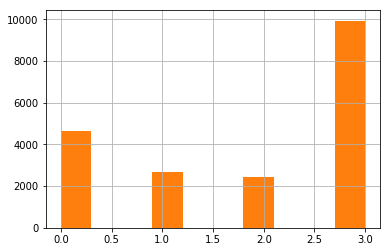

In [20]:
#cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [21]:
#cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
# nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [22]:
weights = {'lbg': 0.80, 'cat': 0, 'xgb': 0.20, 'nn': 0.00}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) 
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [23]:
#pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

{0: 1.3046261051644348, 1: 1.7377341826412769, 2: 1.9695713514421955}


3    0.504
0    0.236
1    0.136
2    0.124
Name: accuracy_group, dtype: float64

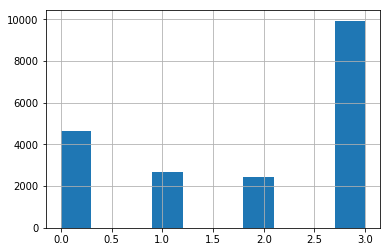

In [24]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)